In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import itertools

# Extended Best Track Dataset

Source: https://rammb2.cira.colostate.edu/research/tropical-cyclones/tc_extended_best_track_dataset/

In [2]:
def read_ebt(filename, basin = None):
    temp = pd.read_fwf(
        filename,
        names = [
            'ID', 'name', 'mdt', 'year', 'lat', 'lon', 'wind', 'pressure_min', 
            'rmw', 'eye_diam', 'pressure_outer', 'radius_outer', 'radii_34', 
            'radii_50', 'radii_64', 'type', 'distance', 'source'
        ],
        infer_nrows=50000,
        dtype = {'mdt':str, 'year':str, 'source':str}
    )

    # Turn dates into correct format
    temp['date'] = temp['year'] + temp['mdt']
    temp['date'] = pd.to_datetime(temp['date'], format = '%Y%m%d%H') 

    # Get independent source columns
    temp['rmw_source'] = temp['source'].str[0]
    temp['eye_diam_source'] = temp['source'].str[1]
    temp['pressure_outer_source'] = temp['source'].str[2]
    temp['radius_outer_source'] = temp['source'].str[3]   

    # Get columns of interest
    temp = temp[['ID', 'date', 'name', 'rmw', 'lat', 'lon', 'wind', 'pressure_min', 'eye_diam', 'pressure_outer', 'radius_outer', 'type', 'distance', 'rmw_source', 'eye_diam_source', 'pressure_outer_source', 'radius_outer_source']]

    if basin:
        if basin == 'AL':
            temp['basin'] = 'AL'
        elif basin == 'EP':
            temp['basin'] = 'EP'
        elif basin == 'CP':
            temp['basin'] = 'CP'

    return temp

In [3]:
files = [
    'data/EBTRK_AL_final_1851-2020_new_format_v3.0.1_23-Aug-2021.txt',
    'data/EBTRK_CP_final_1950-2020_new_format_v3.0.1_23-Aug-2021.txt',
    'data/EBTRK_EP_final_1949-2020_new_format_v3.0.1_23-Aug-2021.txt'
]
basins = ['AL', 'CP', 'EP']

In [4]:
data = pd.concat([read_ebt(f, b) for f, b in zip(files, basins)], ignore_index=True)

### Add "age of storm" to the EBT dataset. 
* Defined as time since storm first reached >=35 kt

In [5]:
# Only keep tc data from 1994 onwards
tc_data = data[data['date'].dt.year >= 1994].copy()

In [6]:
ids = pd.unique(tc_data['ID']) # Get list of storm IDs
tc_data['age'] = -9999 # Initialize age column (in hours)

for id in ids:
    slice = tc_data[tc_data['ID'] == id] # Get slice for storm of interest
    if np.any(slice['wind'] >= 35):
        start_index = np.min(slice.index[slice['wind'] >= 35]) # Index of first time that storm achieves >=35 kt
        start_time = slice.loc[start_index]['date'] # Time that storm first achieves >= 35 kt
        tc_data.loc[slice.index, 'age'] = (slice['date'] - start_time)/np.timedelta64(1, 'h') # Set age as time since start_time (in hours)

In [6]:
# meta data
units = {
    'time':             'UTC',
    'rmw':              'nm',
    'lat':              'deg N',
    'lon':              'deg W',
    'wind':             'kt',
    'pressure_min':     'hPa',
    'eye_diam':         'nm',
    'pressure_outer':   'hPa', 
    'radius_outer':     'nm', 
    'distance':         'km',
    'age':              'hr'
}

source_key = {
    'description':  'Indicates source of data for rmw, eye_diam, pressure_outer, radius_outer',
    '0':            'From b-deck file',
    '1':            'From a-deck CARQ line',
    '2':            'From OFCL at t = 0h',
    '3':            'From OFCL at t = 3h',
    '4':            'From the previous version of the Extended Best Track file',
    '9':            'Variable missing in all sources'
}

# ATCF RMW Measurements from CIMSS Files

In [7]:
more_column_years = np.arange(2008, 2020)

In [8]:
dfs = []
for year in range(1994, 2020):
    if year in more_column_years:
        rows_to_skip = 18
        col_names = ['basin', 'no', 'name', 'date', 'lat', 'lon', 'wind', 'speed', 'pressure', 'r34_q1', 'r34_q2', 'r34_q3', 'r34_q4', 'env_pressure', 'radius_outer', 'rmw', 'speed_2']
    else:
        rows_to_skip = 10
        col_names = ['basin', 'no', 'name', 'date', 'lat', 'lon', 'wind', 'speed', 'pressure']
    
    temp = pd.read_table(
        f'data/reconCIMSS/recon_msw_{year}.txt', 
        sep = ' ', 
        names = col_names,
        skiprows = rows_to_skip,
        dtype = {'no':str}
    )
    temp['date'] = pd.to_datetime(temp['date'].astype(str), format = '%Y%m%d%H')
    temp['ID'] = temp['basin'] + temp['no'].astype(str) + temp['date'].dt.year.astype(str)
    dfs.append(temp[['ID', 'date', 'basin', 'lat', 'lon', 'wind', 'pressure']])

In [9]:
atcf_data = pd.concat(dfs, ignore_index=True).copy()

## Find extended best track observations that fall within three hours of an ATCF observation

In [10]:
full_id_list = pd.unique(tc_data['ID'])
atcf_id_list = pd.unique(atcf_data['ID'])

In [11]:
def atcf_check(row, atcf_df):
    timediffs = [abs(row['date'] - x) for x in atcf_df['date']]
    timediffs_less_than_3hr = [x < pd.Timedelta(3, 'hours') for x in timediffs]
    return np.any(timediffs_less_than_3hr)

In [12]:
# Takes ~30sec to run
tc_data['atcf'] = False

for id in full_id_list:
    if id in atcf_id_list:
        atcf_slice = atcf_data[atcf_data['ID'] == id]
        tc_data.loc[tc_data['ID'] == id, 'atcf'] = tc_data[tc_data['ID'] == id].apply(atcf_check, axis = 1, atcf_df = atcf_slice)

In [13]:
import gc
del atcf_data, full_id_list, atcf_id_list, dfs, data, temp, atcf_slice, basins, col_names, id, more_column_years, rows_to_skip, year
gc.collect()

28

## Output data for capsnet

In [15]:
# Translate nautical miles to kilometers for all related fields:
for col, unit in units.items():
    if unit == 'nm':
        tc_data[col] = np.where(tc_data[col] != -99, tc_data[col] * 1.852, -99) # 1.852 km / 1 nautical mile
        units[col] = 'km'

In [18]:
# Save out data for CapsNet processing later
tc_data[tc_data.date.dt.year >= 2000].to_csv('/VOLUMES/SEAGATE/capsnet/EBT_processed.csv', index = False)

## Continue processing for regression

Apply other restrictions to training data (roughly following the protocol in section 2(c) here: https://arxiv.org/pdf/2106.11809.pdf):
* Data starting in 2004, as this is where the wind estimates are most accurate.
* Only keep data with type != E, to remove extratropical observations (OLD: Only use data with lat < 30 N - not doing this anymore)
* 6km < RMW < 250km, to remove extreme outliers from dataset
* wind >= 35 knots
* distance > 50km
* Just the Atlantic Basin (for now)
* Any where RMW is not defined (= -99)

In [49]:
rmw_data = tc_data[tc_data['date'].dt.year >= 2004]
#rmw_data = rmw_data[rmw_data['lat'] <= 35]
rmw_data = rmw_data[(rmw_data['rmw'] > 6) & (rmw_data['rmw'] < 250)]
rmw_data = rmw_data[rmw_data['wind'] >= 35]
rmw_data = rmw_data[rmw_data['distance'] >= 50]
rmw_data = rmw_data[rmw_data['basin'] == 'AL']
rmw_data = rmw_data[rmw_data['type'] != 'E']
rmw_data = rmw_data[rmw_data['rmw'] != -99].copy(deep = True)

In [53]:
rmw_data.shape
# (4733, 20)

(4733, 20)

In [55]:
rmw_data[rmw_data['atcf']].shape
# (1641, 20)

(1641, 20)

In [56]:
# Save out data
rmw_data.to_csv('data/regression_data.csv', index = False)

# ORB Functions

In [57]:
RAD_DIRECTORY = 'data/ORB/'
SIZE_DIRECTORY = 'data/ORB/'
MIN_YEAR = 2004
MAX_YEAR = 2020

In [58]:
def list_orb_files(file_dir, basin, orb_suffix, min_year, max_year):
    years = [str(i) for i in range(min_year, max_year + 1)]
    files = os.listdir(file_dir)
    rad_files = []
    for f in files:
        if f[4:8] in years:
            if f.startswith(basin):
                if (f[-len(orb_suffix):] == orb_suffix):
                    rad_files.append(f)
        
    return rad_files

In [59]:
rad_files = list_orb_files(RAD_DIRECTORY, 'AL', '-rad.csv', min_year=MIN_YEAR, max_year=MAX_YEAR)
size_files = list_orb_files(SIZE_DIRECTORY, 'AL', '-size.csv', min_year=MIN_YEAR, max_year=MAX_YEAR)

In [60]:
# Size
dfs = []
size_cols = [str(i) for i in range(-1, -100 - 1, -1)]
for f in size_files:
    path = SIZE_DIRECTORY + f
    storm_id = f.split('-')[0]
    df = pd.read_csv(path)
    df['time'] = pd.to_datetime(df['time']).dt.round('min')
    df['ID'] = storm_id
    dfs.append(df)
df_size = pd.concat(dfs)
df_size.sort_values(by = ['time'], inplace=True)

In [61]:
# Radius
dfs = []
rad_cols = [str(i) for i in range(5, 600 + 5, 5)]
for f in rad_files:
    path = RAD_DIRECTORY + f
    storm_id = f.split('-')[0]
    df = pd.read_csv(path)
    df['time'] = pd.to_datetime(df['time']).dt.round('min')
    cols = ['time']
    cols.extend(rad_cols)
    df.columns = cols
    df['ID'] = storm_id
    dfs.append(df)
df_rad = pd.concat(dfs)
df_rad.sort_values(by = ['time'], inplace=True)

## Normalize the size function by area of stamp

Because the raw values are in number of pixels, but different stamps have different number of pixels, depending on their latitude. 

In [62]:
# Attach latitude values to size functions
df_size_lat = df_size.merge(tc_data[['ID', 'date', 'lat']].rename(columns = {'date': 'time'}), 'left', on = ['ID', 'time'])

# Interpolate the non-synoptic time latitudes using linear interpolation
ids = pd.unique(df_size['ID'])
for id in ids:
    df_size_lat.loc[df_size_lat['ID'] == id, 'lat'] = df_size_lat.loc[df_size_lat['ID'] == id, 'lat'].interpolate()
df_size_lat['lat'] = df_size_lat['lat'].round(1)

In [63]:
# Functions for normalizing size function
def distance_from_coord(lat1, lat2, lon1, lon2):
    """
    Return distance in KM given a pair of lat-lon coordinates.
    :param lat1: Starting latitude
    :param lat2: Ending latitude
    :param lon1: Starting Longitude
    :param lon2: Ending longitude
    :return: Arc length of great circle
    """
    # https://www.movable-type.co.uk/scripts/latlong.html
    R = 6371
    latDel = lat1 - lat2
    lonDel = lon1 - lon2
    a = (
            np.sin(latDel / 2 * np.pi / 180) ** 2 +
            np.cos(lat1 * np.pi / 180) * np.cos(lat2 * np.pi / 180) *
            np.sin(lonDel / 2 * np.pi / 180) ** 2
    )
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

def coord_from_distance(lat, lon, distance):
    """
    Find the bounding box for the stamp based on center coord and distance
    :param lat: Latitude of stamp center
    :param lon: Longitude of stamp center
    :param distance: Stamp radius
    :return: Dictionary of bounding latitudes and longitudes for stamp
    """
    # https://www.movable-type.co.uk/scripts/latlong.html
    R = 6371
    latEnd = [float()] * 360
    lonEnd = [float()] * 360
    bearings = range(0, 360)
    distance = float(distance)
    ii = 0
    for bearing in bearings:
        latEnd[ii] = np.arcsin(np.sin(lat * np.pi / 180) * np.cos(distance / R) +
                               np.cos(lat * np.pi / 180) * np.sin(distance / R) *
                               np.cos(bearing * np.pi / 180)
                               ) * 180 / np.pi
        lonEnd[ii] = lon + np.arctan2(
            np.sin(bearing * np.pi / 180) * np.sin(distance / R) * np.cos(lat * np.pi / 180),
            np.cos(distance / R) - np.sin(lat * np.pi / 180) * np.sin(latEnd[ii] * np.pi / 180)
        ) * 180 / np.pi
        ii += 1
    return ({
        'latHi': np.max(latEnd),
        'latLo': np.min(latEnd),
        'lonHi': np.max(lonEnd),
        'lonLo': np.min(lonEnd)
    })


stamp_area_cached = {}
def stamp_area(lat, distance=400, resolution=0.04):
    """
    Find the number of pixels in a stamp at a given latitude
    :param lat: Latitude of stamp center
    :param distance: Stamp radius
    :return: integer number of pixels in image
    """
    global stamp_area_cached
    if stamp_area_cached.get(lat):
        return stamp_area_cached.get(lat)
    bbox = coord_from_distance(lat, 0, distance)
    # Build the grid
    latpix = np.int(np.ceil((bbox['latHi'] - bbox['latLo']) / resolution))
    if latpix % 2 == 0:
        latpix += 1
    lonpix = np.int(np.ceil((bbox['lonHi'] - bbox['lonLo']) / resolution))
    if lonpix % 2 == 0:
        lonpix += 1
    lats = [resolution*(ii - np.floor(latpix/2)) for ii in range(latpix)]
    lons = [resolution*(ii - np.floor(lonpix/2)) for ii in range(lonpix)]
    grid = np.array(np.meshgrid(lats, lons)).reshape(2, latpix*lonpix).T
    # Compute radii over grid
    rads = distance_from_coord(lat * np.ones((grid.shape[0])),
                               lat * np.ones((grid.shape[0])) + grid[:, 0],
                               np.zeros((grid.shape[0])),
                               grid[:, 1])
    val = np.sum(rads < distance)
    stamp_area_cached[lat] = val
    return val

In [64]:
df_size_lat['stamp_area'] = df_size_lat['lat'].apply(stamp_area, distance = 400)

/var/folders/8c/sdszflfs5bx2dtnzl3j1xk7c0000gn/T/ipykernel_56559/3969393699.py:69: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  latpix = np.int(np.ceil((bbox['latHi'] - bbox['latLo']) / resolution))
/var/folders/8c/sdszflfs5bx2dtnzl3j1xk7c0000gn/T/ipykernel_56559/3969393699.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precis

In [65]:
for col in size_cols:
    df_size[col] = df_size[col].to_numpy()/df_size_lat['stamp_area'].to_numpy(dtype = 'float')

In [66]:
del df_size_lat
gc.collect()

277

## PCA for ORBs

In [67]:
from sklearn.decomposition import PCA

In [68]:
MIN_TEST_YEAR = 2017

### Radius

In [69]:
# Get rid of rows with nans
df_rad_clean = df_rad.loc[df_rad.isnull().sum(axis = 1) == 0].copy()

In [70]:
pca_rad = PCA(n_components=3)
X_rad = df_rad_clean.loc[df_rad_clean.time.dt.year < MIN_TEST_YEAR, rad_cols]
X_rad_centered = X_rad - X_rad.mean(axis = 0)
pca_rad.fit(X_rad_centered)
pca_rad_applied = pca_rad.transform(df_rad_clean.loc[:, rad_cols] - X_rad.mean(axis = 0))
df_rad_clean[['rad_pc_1', 'rad_pc_2', 'rad_pc_3']] = pca_rad_applied

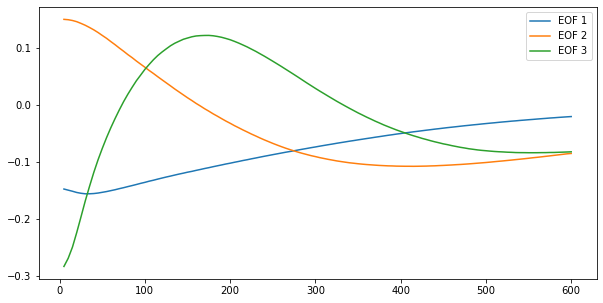

In [71]:
x_rad = np.array(rad_cols, dtype = 'int')
plt.figure(figsize = (10, 5))
for i in range(3):  
    plt.plot(x_rad, pca_rad.components_[i,:], label = f'EOF {i + 1}')

plt.legend()
plt.show()

### Size

In [72]:
# Get rid of rows with nans
df_size_clean = df_size.loc[df_size.isnull().sum(axis = 1) == 0].copy()

In [73]:
pca_size = PCA(n_components=3)
X_size = df_size_clean.loc[df_size_clean.time.dt.year < MIN_TEST_YEAR, size_cols]
X_size_centered = X_size - X_size.mean(axis = 0)
pca_size.fit(X_size_centered)
pca_size_applied = pca_size.transform(df_size_clean.loc[:, size_cols] - X_size.mean(axis = 0))
df_size_clean[['size_pc_1', 'size_pc_2', 'size_pc_3']] = pca_size_applied

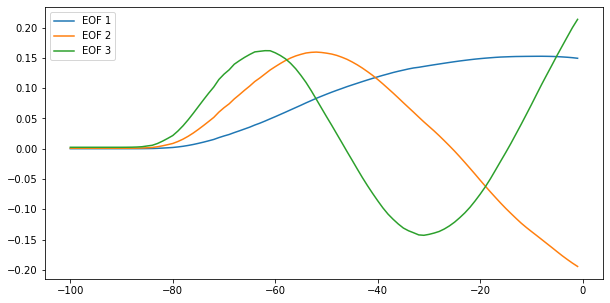

In [74]:
x_size = np.array(size_cols, dtype = 'int')
plt.figure(figsize = (10, 5))
for i in range(3):  
    plt.plot(x_size, pca_size.components_[i,:], label = f'EOF {i + 1}')

plt.legend()
plt.show()

## Quadrants

Run this block if you need to re-do the cleaning at all (takes a while), otherwise just read the CSV. 

In [ ]:
import structuralmodels as stcip

# WORK ON THIS - SEE WHY THERE ARE STILL NA VALUES IN THE DOWNSAMPLE AND IF THAT'S A PROBLEM

fp = '/Volumes/SEAGATE/ORB_quadrants/csvs' # Make sure external HD is plugged in

# Takes ~ 1min to run
stcip_data = stcip.PrimaryData(fp, fp, 'AL', minyear = 2000, maxyear = 2020)
stcip_data.data.to_csv('data/rad_quadrants_full_unaltered.csv', index = False)

# Takes ~2.25min to run 
stcip_data.downscale_(stcip_data._max_resample, resolution = '2H', window = '1H', threshold=0.1)

# Takes ~15sec to run
stcip_data.interpolate_lone_rows_()

stcip_data.data.to_csv('data/rad_quadrants_downsampled_cleaned.csv', index = False)

In [199]:
df_rad_quad_cleaned = pd.read_csv('data/rad_quadrants_downsampled_cleaned.csv')
df_rad_quad_cleaned['timestamp'] = pd.to_datetime(df_rad_quad_cleaned['timestamp'])
df_rad_quad_cleaned['target'] = pd.to_datetime(df_rad_quad_cleaned['target'])
df_rad_quad_cleaned['lag'] = pd.to_timedelta(df_rad_quad_cleaned['lag'])

In [200]:
rad_cols_rq = [str(i) for i in range(5, 400 + 5, 5)]
suffixes = ['_NE', '_NW', '_SW', '_SE']
rad_cols_all = [y + x for x, y in itertools.product(suffixes, rad_cols_rq)]

In [201]:
#get min
df_rad_quad_cleaned['min'] = df_rad_quad_cleaned[rad_cols_all].idxmin(axis = 1)
df_rad_quad_cleaned[['min_rad', 'min_quad']] = df_rad_quad_cleaned['min'].str.split('_', expand = True)
df_rad_quad_cleaned['min_rad'] = pd.to_numeric(df_rad_quad_cleaned['min_rad'])
df_rad_quad_cleaned.drop('min', axis = 1, inplace = True)

In [32]:
df_rad_quad_cleaned[['timestamp', 'min_rad', 'min_quad']]

,timestamp,min_rad,min_quad
0,2000-06-07 18:00:00,115.0,SE
1,2000-06-07 20:00:00,140.0,SE
2,2000-06-07 22:00:00,315.0,SE
3,2000-06-08 00:00:00,380.0,SE
4,2000-06-08 02:00:00,390.0,SE
...,...,...,...
31686,2020-11-18 04:00:00,325.0,NW
31687,2020-11-18 06:00:00,370.0,NW
31688,2020-11-18 08:00:00,175.0,NW
31689,2020-11-18 10:00:00,200.0,NW


<AxesSubplot:>

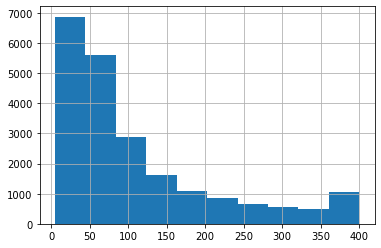

In [193]:
df_rad_quad_cleaned.loc[df_rad_quad_cleaned['WIND'] >= 35, 'min_rad'].hist()

### PCA for the quadrants
* Filter to wind $\geq$ 35 kt
* Perform PCA using all 4 quadrants at once (sumamrizing equivalent patterns over all quadrants)
* Get PCs for each quadrant individually

In [243]:
# Filter to >= 35 kt
df_rq_wind_filtered = df_rad_quad_cleaned[df_rad_quad_cleaned['WIND'] >= 35]
df_rq_wind_filtered = df_rq_wind_filtered.loc[df_rq_wind_filtered.isna().sum(axis = 1) == 0]

In [244]:
# Re-arange df_rad_quad_cleaned into a dataframe where columns are 5, 10, ..., 400 and rows are 4x more than in the current DF
rq_list = []
for suffix in suffixes:
    target_cols = [x + suffix for x in rad_cols_rq]
    df_temp = df_rq_wind_filtered[target_cols].copy()
    df_temp.columns = rad_cols_rq
    df_temp['time'] = df_rq_wind_filtered['timestamp']
    rq_list.append(df_temp)

df_rq = pd.concat(rq_list, axis = 0, ignore_index=True)

In [245]:
pca_rad_quad = PCA(n_components=3)
X_rq = df_rq.loc[df_rq.time.dt.year < MIN_TEST_YEAR, rad_cols_rq]
X_rq_centered = X_rq - X_rq.mean(axis = 0)
pca_rad_quad.fit(X_rq_centered)

PCA(n_components=3)

In [251]:
# Apply to appropriate columns x4
for suffix in suffixes:
    target_cols = [x + suffix for x in rad_cols_rq]
    result_cols = ['rad_pc_' + x + suffix for x in ['1', '2', '3']]
    temp_df = df_rq_wind_filtered[target_cols]
    temp_df.columns = rad_cols_rq

    df_rq_wind_filtered[result_cols] = pca_rad_quad.transform(temp_df - X_rq.mean(axis = 0))

In [263]:
df_rq_tomerge = df_rq_wind_filtered.drop(rad_cols_all + ['LAT', 'WIND', 'target', 'lag'], axis = 1)
df_rq_tomerge.rename(columns = {'timestamp': 'date'}, inplace = True)

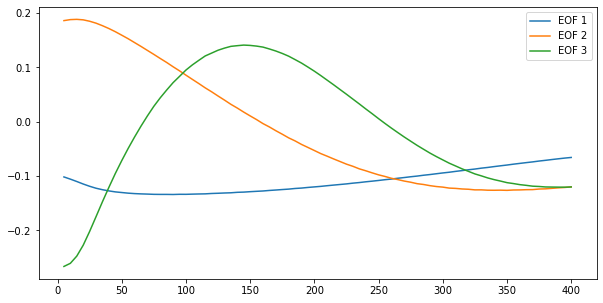

In [235]:
x_rq = np.array(rad_cols_rq, dtype = 'int')
plt.figure(figsize = (10, 5))
for i in range(3):  
    plt.plot(x_rq, pca_rad_quad.components_[i,:], label = f'EOF {i + 1}')

plt.legend()
plt.show()

## Merge ORB stuff with rest of data

In [75]:
# Merge 
df_size_rad = df_size_clean.merge(df_rad_clean, how='inner', on=['time', 'ID'])
df_size_rad.shape

(102908, 228)

In [76]:
orb_data = df_size_rad.rename(columns = {'time': 'date'})

In [77]:
df_orb_tc = rmw_data.merge(orb_data, how='inner', on=['date', 'ID'])
df_orb_tc.shape

(4698, 246)

In [78]:
import gc
del df, dfs, rad_files, size_files
gc.collect()

7163

Add Lags at -6, -4, -2, -1, +1, +2, +4, +6 hr for all PCA coefficients

In [81]:
def get_lagged_pcs(row, time_diff, fn):
    target_cols = [x + '_pc_' + y for x, y in itertools.product([fn], ['1', '2', '3'])]
    target_time = row['date'] + pd.Timedelta(time_diff, 'h')
    
    if fn == 'rad':
        temp = df_rad_clean
    elif fn == 'size':
        temp = df_size_clean

    result = temp.loc[temp['time'] == target_time, target_cols]
    
    if len(result) > 0:
        return result.iloc[0]
    else:
        return pd.Series({fn+'_pc_1': np.nan, fn+'_pc_2':np.nan, fn+'_pc_3':np.nan})

for fn in ['rad', 'size']:
    for lag in [-12, -9, -6, 6, 9, 12]:
        lag_suffix = str(lag)+'p' if lag > 0 else str(abs(lag))+'m' 
        temp_col_names = [x+'_pc_'+y+'_'+lag_suffix for x, y in itertools.product([fn], ['1', '2', '3'])]

        df_orb_tc[temp_col_names] = df_orb_tc.apply(lambda x: get_lagged_pcs(x, lag, fn), axis = 1, result_type = 'expand')

In [82]:
df_orb_tc_pca_only = df_orb_tc.drop(rad_cols + size_cols, axis = 1)

In [83]:
df_orb_tc_pca_only.to_csv('data/regression_data_pca_lagged.csv', index = False)

Add quadrant PCs

In [278]:
# Left merge because there's some missingness in the quadrant's that I don't want to deal with just yet
df_orb_tc_quad = df_orb_tc.merge(df_rq_tomerge, how = 'left', on = ['date', 'ID'])

In [279]:
df_orb_tc_quad_smaller = df_orb_tc_quad.drop(rad_cols + size_cols, axis = 1)

In [280]:
df_orb_tc_quad_smaller.to_csv('data/regression_data_pca_lagged_quad.csv', index = False)

# EDA

In [87]:
df = df_orb_tc_pca_only

array([[<AxesSubplot:title={'center':'rmw'}>,
        <AxesSubplot:title={'center':'lat'}>,
        <AxesSubplot:title={'center':'lon'}>],
       [<AxesSubplot:title={'center':'wind'}>,
        <AxesSubplot:title={'center':'pressure_min'}>,
        <AxesSubplot:title={'center':'distance'}>]], dtype=object)

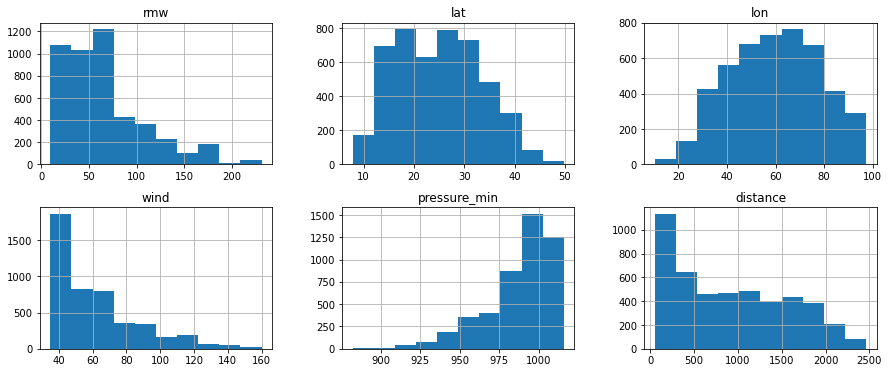

In [88]:
df[['rmw', 'lat', 'lon', 'wind', 'pressure_min', 'distance']].hist(figsize = (15, 6), layout = (2, 3))

In [89]:
import seaborn as sns

In [90]:
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})

<AxesSubplot:xlabel='lat', ylabel='rmw'>

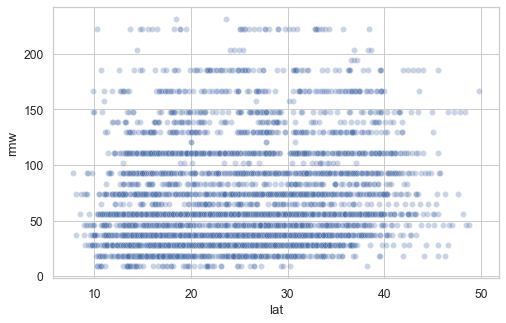

In [91]:
sns.scatterplot(x=df['lat'], y=df['rmw'], alpha = 0.3)

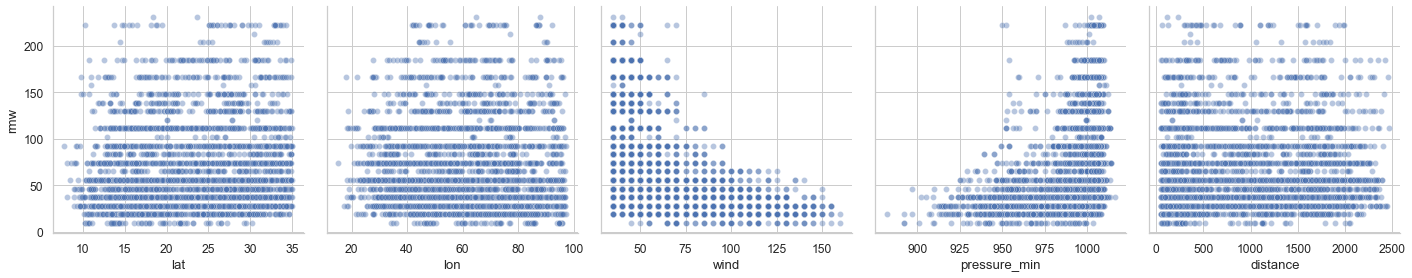

In [49]:
g = sns.PairGrid(df, y_vars=['rmw'], x_vars=['lat', 'lon', 'wind', 'pressure_min', 'distance'], height = 4)
g.map(sns.scatterplot, alpha = 0.4)

<AxesSubplot:xlabel='wind', ylabel='pressure_min'>

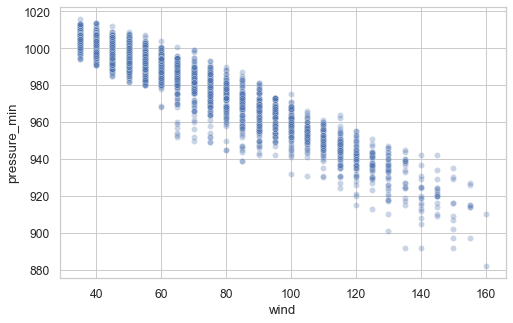

In [50]:
sns.scatterplot(x = df['wind'], y = df['pressure_min'], alpha = 0.3)

<AxesSubplot:xlabel='lat', ylabel='rmw'>

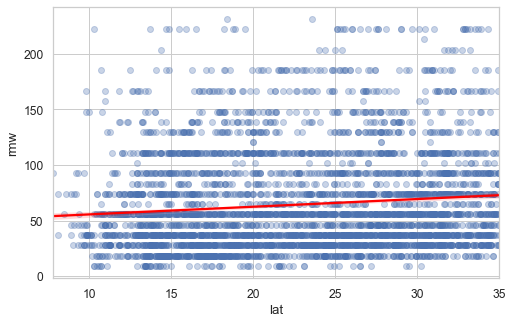

In [51]:
sns.regplot(x = df['lat'], y = df['rmw'], scatter_kws = {'alpha': 0.3}, line_kws = {'color': 'red'})

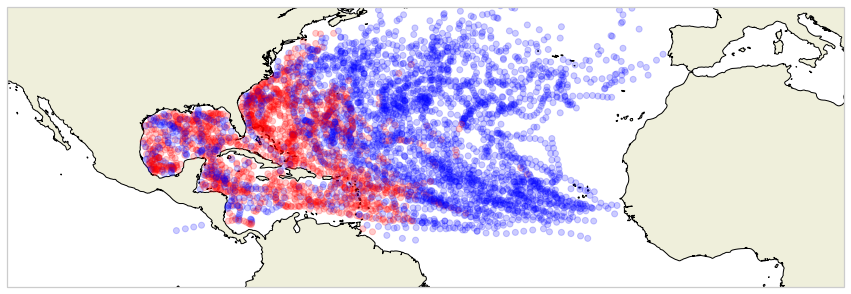

In [92]:
import cartopy.crs as ccrs       # cartopy 0.18.0
import cartopy.feature 

import matplotlib.pyplot as plt  # matplotlib 3.3.0

central_lat = 37.5
central_lon = -96
extent = [-120, 20, 0, 20]

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent)
#ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND, edgecolor = 'black')
scatter = ax.scatter(-1*df['lon'], df['lat'], transform = ccrs.PlateCarree(), alpha = 0.2, c = df['atcf'].apply(lambda x: 'red' if x else 'blue'))

The above shows that the majority of the ATCF fixes occured in the Atlantic basin, closer to the coast than out at sea. 

In [93]:
rmw_data.groupby(['basin', 'atcf']).size()

basin  atcf 
AL     False    3092
       True     1641
dtype: int64

In [95]:
df.groupby('atcf').size()

atcf
False    3062
True     1636
dtype: int64

CREATE A FEATURE THAT IS JUST THE RADIUS OF MINIMUM TEMPERATURE OVER THE FOUR QUADRANTS.